In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from rdkit import Chem
from wandb.proto import wandb_internal_pb2
from wandb.sdk.internal import datastore

### DiffSBDD

In [2]:
# Get average ligand "size" (defined in DiffSBDD as number of atoms)
train_ligands = np.load("DiffSBDD_BindingMOAD_preprocessed/train.npz")
dataset = pd.read_csv("BindingMOAD_filtered_set_for_retraining_with_split_4_Pocket2Mol.csv")


In [3]:
unique_train_ligs = list(set([lig.split("_")[1].split(":")[0] for lig in list(train_ligands["names"])]))


In [4]:
train_num_mol_atoms = []

for lig in unique_train_ligs:
    lig_smi = dataset[dataset["Ligand ID"] == lig]["SMILES"].unique()
    mol = Chem.MolFromSmiles(lig_smi[0])
    if mol is not None:
        train_num_mol_atoms.append(len(mol.GetAtoms()))
    

[04:07:53] Explicit valence for atom # 7 Cl, 5, is greater than permitted


In [5]:
ave_lig_num_atoms = np.mean(train_num_mol_atoms)


In [6]:
import os
os.chdir(<diffsbdd_dir>)


In [7]:
from dataset import ProcessedLigandPocketDataset
from pathlib import Path
from constants import dataset_params

/hpc/mydata/upt/ns833749/DiffSBDD/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_dataset = ProcessedLigandPocketDataset(
                Path("DiffSBDD_BindingMOAD_preprocessed", 'train.npz'), transform=None)


In [9]:
len(dataset_params['bindingmoad']['atom_decoder'])

10

In [61]:
data_path = "DiffSBDD/logging_benchmark_v2/wandb/offline-run-20240223_033715-SE3-cond-fullAtom-Benchmark_with_logging/run-SE3-cond-fullAtom-Benchmark_with_logging.wandb"
ds = datastore.DataStore()
ds.open_for_scan(data_path)

train_losses = {}
val_losses = {}

while True:
    data = ds.scan_data()
    if data is None:
        break
    pb = wandb_internal_pb2.Record()
    pb.ParseFromString(data)
    record_type = pb.WhichOneof("record_type")
    if record_type == "history":
        if len(pb.history.item) == 16:
            #print(pb.history.item)
            train_or_val_loss = pb.history.item[2]
            epoch = pb.history.item[11]
            if 'train' in train_or_val_loss.key:
                if float(epoch.value_json) in train_losses.keys():
                    train_losses[float(epoch.value_json)].append(float(train_or_val_loss.value_json))
                else:
                    train_losses[float(epoch.value_json)] = []
            else:
                val_losses[float(epoch.value_json)] = float(train_or_val_loss.value_json)/((ave_lig_num_atoms*3)+(len(dataset_params['bindingmoad']['atom_decoder'])*ave_lig_num_atoms))

In [11]:
train_losses_mean = {}
for key, val in train_losses.items():
    train_losses_mean[key] = sum(val)/len(val)

In [12]:
train_df = pd.DataFrame(train_losses_mean.items(), columns=["Epoch", "Train error"])
val_df = pd.DataFrame(val_losses.items(), columns=["Epoch", "Validation error"])


In [13]:
## Loss = MSE of noise added to each atom (epsilon)

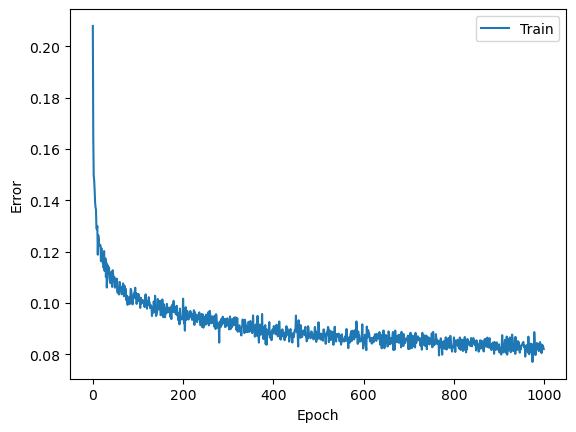

In [14]:
sns.lineplot(train_df, x="Epoch", y="Train error", label="Train")
plt.ylabel("Error")
plt.legend()
plt.show()

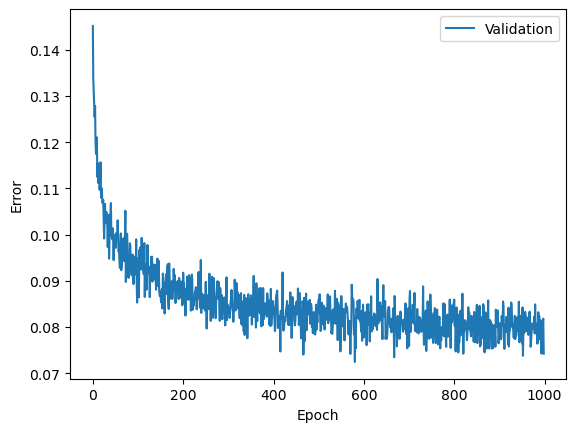

In [15]:
sns.lineplot(val_df, x="Epoch", y="Validation error", label="Validation")
plt.ylabel("Error")
plt.legend()
plt.show()

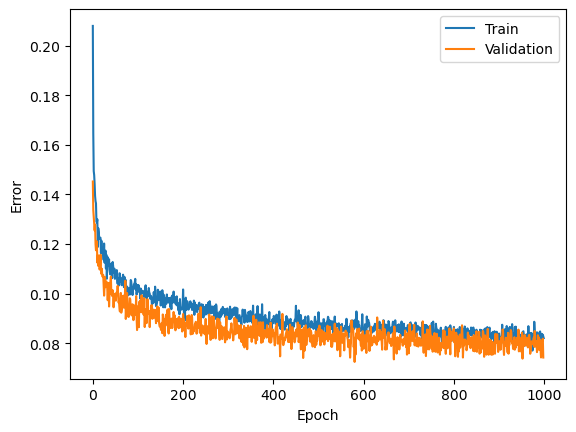

In [16]:
sns.lineplot(train_df, x="Epoch", y="Train error", label="Train")
sns.lineplot(val_df, x="Epoch", y="Validation error", label="Validation")
plt.ylabel("Error")
plt.legend()
plt.show()

### Pocket2Mol

In [17]:
output_file = "/hpc/projects/upt/SBDD_benchmarking/Pocket2Mol/slurm-4455329.out"

training_output = {}
validation_output = {}

with open(output_file, "r") as o:
    lines = o.readlines()
    
    for line in lines:
        if "[Train]" in line:
            training_vals = line.strip().replace(' ', '').split('[Train]')[1].split('|')
            training_output[int(training_vals[0].split("Iter")[1])] = float(training_vals[1].split("Loss")[1])
            
        if "[Validate]" in line:
            validation_vals = line.strip().replace(' ', '').split('[Validate]')[1].split('|')
            validation_output[int(validation_vals[0].split("Iter")[1])] = float(validation_vals[1].split("Loss")[1])
            

In [18]:
train_p2m_df = pd.DataFrame(training_output.items(), columns=["Epoch", "Train loss"])
val_p2m_df = pd.DataFrame(validation_output.items(), columns=["Epoch", "Validation loss"])


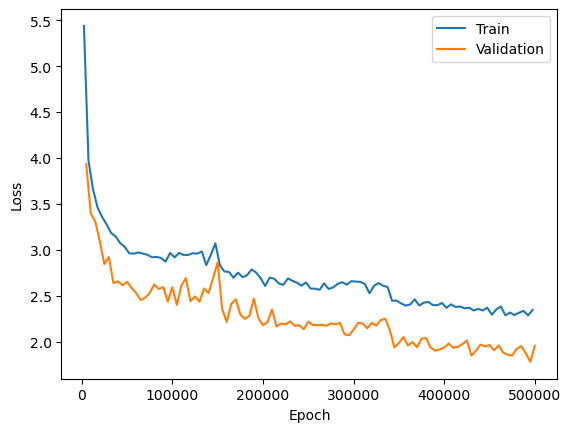

In [19]:
sns.lineplot(train_p2m_df.groupby(train_p2m_df.index // 5000).mean(), x="Epoch", y="Train loss", label="Train")
sns.lineplot(val_p2m_df, x="Epoch", y="Validation loss", label="Validation")
plt.ylabel("Loss")
plt.legend()
plt.show()